In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Understanding the Format of Data Returned by a Simulation

Running simulations of NEC5 antenna designs involves creating each design as a single python string, then passing a list of any number of designs to one of the nec_sim_* functions:
```python
results = nec_sim_stdio3([design0, design1, ...])
```
which will execute the simulations as separate processes and return a nested list of results, described in detail below.

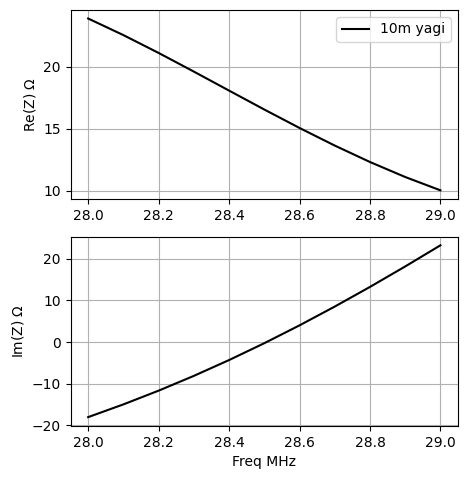

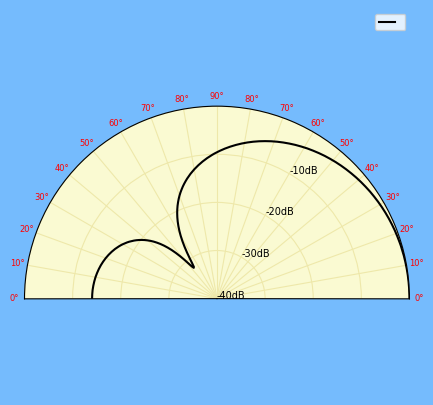

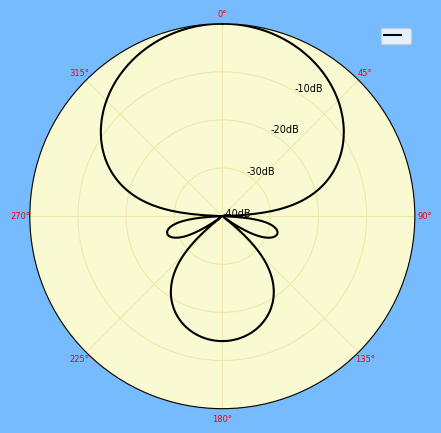

In [47]:
from necutil import nec5_sim_stdio3, plot_complex_z, plot_azimuth2, plot_elevation, plot_vswr

yagi = '\n'.join(
    ['CE 3-el Yagi in free space',               
     'GW 1 20 -0.914 -2.796 0 -0.914 2.796 0 .0064',    # R
     'GW 2 20 0 -2.561 0 0 2.561 0 .0064',              # DE
     'GW 3 20 1.37 -2.446 0 1.37 2.446 0 .0064',        # D
     'GE 0 0',                                          # End of geometry; no ground plane specified
     'EX 4 2 10 2 1.0 0.0',                             # Excitation: current source (1A), tag=2, segment=10, far end=2
     'FR 0 11 0 0 28.0 0.1',                            # Frequencies for XQ card: 28.0 - 29.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance
     'FR 0 11 0 0 26.0 0.4',                            # Frequencies for XQ card: 26.0 - 30.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance
     'FR 0 3 0 0 28.0 0.5',                             # Frequencies for RP card: 28.0, 28.5, 29.0 MHz
     'RP 0 91 360 0000 0 0 1 1',                        # Simulate radiation pattern on 10deg grid
     'FR 0 1 0 0 28.5 0',                               # Frequency for RP card: 28.5 MHz
     'RP 0 91 360 0000 0 0 1 1',                        # Simulate radiation pattern on 1deg grid
     'EN\n'                                             # End
    ])

result = nec5_sim_stdio3([yagi])


rparr = result[0][1][0][1][1]                           # Rad pattern array returned from simulation
plot_complex_z([result[0][0][0]], ['10m yagi'])         # Feedpoint Z
plot_elevation([rparr], [''])                           # Elevation
plot_azimuth2([rparr], [0], [''])  # Azimuth

The data structure ```result``` returned here is a nested list of data produced by the XQ and RP cards in each design:
```
result[design#] [0 for XQ, 1 for RP] [result set#]
```
The above design has two 'XQ' cards, so there are two result sets:

```
result[0][0][0] =                   # [design# 0][XQ results][first XQ card]
    [[28.0, (23.862-18.013j)],      # List of frequency/complex-z pairs
     [28.1, (22.528-14.956j)],
     [28.2, (21.092-11.658j)],
    ...

result[0][0][1] =                   # [design# 0][XQ results][second XQ card]
    [[26.0, (7.804-80.93j)],        # List of frequency/complex-z pairs
     [26.4, (14.049-60.943j)],
     [26.8, (21.895-46.519j)],
    ...

```
There are two 'RP' cards in the design, so there are also two result sets:
```
result[0][1][0] =                   # [design# 0][RP results][first RP card]
    [[28.0, <array>],               # List of frequency/radiation pattern arrays
     [28.5, <array>],
     [29.0, <array>]
    ]

result[0][1][1] =                   # [design# 0][RP results][second RP card]
    [[28.5, <array>]                # List of frequency/radiation pattern arrays
    ]

```


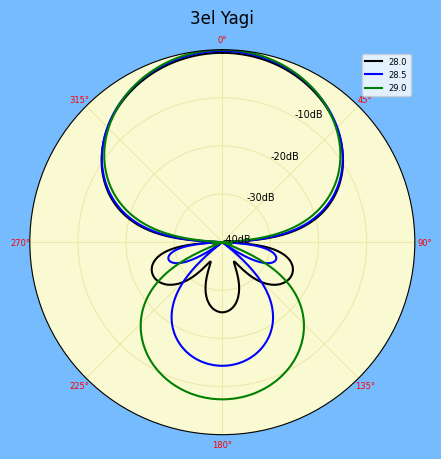

In [38]:
# The display functions can take lists of results...

rps = result[0][1][0]           # [ [freq0, array0], [freq1, array1], ... ]
freqs, rparrays = zip(*rps)     # 'Unzip' to produce list of freqs and list of arrays

plot_azimuth2(rparrays, [0]*3, freqs, '3el Yagi') 

## Multiple designs in one deck
Placing multiple geometries in one deck will produce multiple result sets just like in the previous discussion, e.g. ```result[0][0][0]``` is the result from the first antenna's XP card, etc.
This might be useful in maximizing throughput in optimization algorithms - more testing needed.

In [51]:
# Three independent dipole geometries
three_dipoles = '\n'.join(
    ['CE Three independent geometries',               
     'GW 1 20 0 -2.50 0 0 2.50 0 .0064',  
     'GE 0 0',                                          # End of geometry; no ground plane specified
     'EX 4 1 10 2 1.0 0.0',                             # Excitation: current source (1A), tag=1, segment=10, far end=2
     'FR 0 11 0 0 27.0 0.2',                            # Frequencies for XQ card: 27.0 - 29.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance

     'NX',                                              # Next geometry

     'GW 1 20 0 -5.0 0 0 5.0 0 .0064',  
     'GE 0 0',                                          # End of geometry; no ground plane specified
     'EX 4 1 10 2 1.0 0.0',                             # Excitation: current source (1A), tag=1, segment=10, far end=2
     'FR 0 11 0 0 13.0 0.2',                            # Frequencies for XQ card: 13.0 - 15.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance

     'NX',                                              # Next geometry

     'GW 1 20 0 -10.0 0 0 10.0 0 .0064',  
     'GE 0 0',                                          # End of geometry; no ground plane specified
     'EX 4 1 10 2 1.0 0.0',                             # Excitation: current source (1A), tag=1, segment=10, far end=2
     'FR 0 11 0 0 6.0 0.2',                             # Frequencies for XQ card: 6.0 - 8.0 MHz
     'XQ 0',                                            # Simulate feedpoint impedance

     'EN\n'                                             # End
    ])

result = nec5_sim_stdio3([three_dipoles])


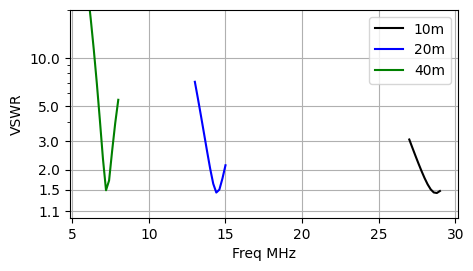

In [52]:
# result[0][0] is a list of the XP results for the three antennas
plot_vswr(result[0][0], ['10m','20m','40m'])